# Analyze Motion Data from the SenseHat of my Raspberry PI

With the TjBot based on Raspberry Pi the motion sensor data (acc, gyro, compass, ..) from the SenseHAT will be pushed through the IoT Foundation via MQTT into a cloudant DB. With this python notebook you will be able to collect this data and create some visualisations.

With this python notebook you will be able to

- collect this data and create some visualisations
- and to train a support vector classifier

## Install the necessary python libraries missing by default

In [1]:
!pip install cloudant

     |████████████████████████████████| 61kB 8.5MB/s  eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a1/88/1a/4211b73f602be4834dc4639f947fba1c8266326b60fd22103b
Successfully built cloudant


## Get the credentials to access the cloudant DB

Use the existing connection document (CloudandDB) and push "insert code" rename it to credentials.

In [2]:
# The code was removed by Watson Studio for sharing.

## Import the Cloudant API and configure DB

In [3]:
from cloudant.client import Cloudant
from cloudant.result import Result, ResultByKey
from cloudant.query import Query

client = Cloudant(credentials_1['username'], credentials_1['password'], 
                  url=credentials_1['custom_url'], 
                  connect=True)

Select the DB within the Cloudant Service

In [4]:
database = client['motions']

### Construct Query

Create a Query on the CloudantDB like

SELECT d.device, d.figure, d.motionset, d.date, d.timestamp, d.acceleration FROM Motions WHERE _id >= 0;

In [5]:
# Create Selector
selector = {
    '_id' : {'$gt' : 0} 
    #,
    #'datetime' : {'$gte' : '2019-12-02', '$lt': '2019-12-03'}
}

# Select Fields
fields = [
    'd.device',
    'd.figure',
    'd.motionset',
    'd.date',
    'd.timestamp',
    'd.acceleration'
]

# Create Query
motion_query = Query(
    database,
    selector = selector,
    fields = fields
)

Check the outcome for the DB

In [6]:
# show 5 elements
for doc in motion_query(limit=5)['docs']:
    print(doc)

{'d': {'device': 'tjbot-01', 'figure': '0', 'motionset': '2019-12-16T07:37:44.372Z', 'date': '2019-12-16T07:37:45.136Z', 'timestamp': 1576481865136, 'acceleration': {'x': 0.987, 'y': 0.0731, 'z': 0.2166}}}
{'d': {'device': 'tjbot-01', 'figure': '0', 'motionset': '2019-12-16T07:37:44.372Z', 'date': '2019-12-16T07:37:45.887Z', 'timestamp': 1576481865887, 'acceleration': {'x': 0.9821, 'y': 0.0714, 'z': 0.1998}}}
{'d': {'device': 'tjbot-01', 'figure': '0', 'motionset': '2019-12-16T07:37:44.372Z', 'date': '2019-12-16T07:37:46.759Z', 'timestamp': 1576481866759, 'acceleration': {'x': 0.9923, 'y': 0.0656, 'z': 0.1945}}}
{'d': {'device': 'tjbot-01', 'figure': '0', 'motionset': '2019-12-16T07:40:07.162Z', 'date': '2019-12-16T07:40:07.541Z', 'timestamp': 1576482007541, 'acceleration': {'x': 0.9931, 'y': -0.0022, 'z': 0.1292}}}
{'d': {'device': 'tjbot-01', 'figure': '0', 'motionset': '2019-12-16T07:40:07.162Z', 'date': '2019-12-16T07:40:07.633Z', 'timestamp': 1576482007633, 'acceleration': {'x': 0

## Using pandas for the data processing

In [7]:
import pandas as pd
from pandas import date_range, to_datetime
from pandas.io.json import json_normalize
from pandas import Timestamp, DataFrame, Series, Timedelta, concat
from pandas import date_range

### Store the data in an array as a table

Also rename the columns for better reading afterwards

In [8]:
df = pd.DataFrame.from_dict(json_normalize(list(motion_query()['docs'])).rename(columns = {
    'd.device' : 'device',
    'd.figure' : 'figure',
    'd.motionset' : 'motionset',
    'd.timestamp' : 'timestamp',
    'd.date' : 'date',
    'd.acceleration.x' : 'acc_x',
    'd.acceleration.y' : 'acc_y',
    'd.acceleration.z' : 'acc_z'
}), orient='columns')

df.head()

,acc_x,acc_y,acc_z,date,device,figure,motionset,timestamp
0,0.9870,0.0731,0.2166,2019-12-16T07:37:45.136Z,tjbot-01,0,2019-12-16T07:37:44.372Z,1576481865136
1,0.9821,0.0714,0.1998,2019-12-16T07:37:45.887Z,tjbot-01,0,2019-12-16T07:37:44.372Z,1576481865887
2,0.9923,0.0656,0.1945,2019-12-16T07:37:46.759Z,tjbot-01,0,2019-12-16T07:37:44.372Z,1576481866759
3,0.9931,-0.0022,0.1292,2019-12-16T07:40:07.541Z,tjbot-01,0,2019-12-16T07:40:07.162Z,1576482007541
4,0.9918,0.0267,0.1533,2019-12-16T07:40:07.633Z,tjbot-01,0,2019-12-16T07:40:07.162Z,1576482007633


### Reorganize the array and sort

In [9]:
cols = df.columns.tolist()
cols

['acc_x',
 'acc_y',
 'acc_z',
 'date',
 'device',
 'figure',
 'motionset',
 'timestamp']

In [10]:
cols = ['device', 'figure', 'motionset', 'date', 'timestamp', 'acc_x', 'acc_y', 'acc_z']
df = df[cols]
df.head()

,device,figure,motionset,date,timestamp,acc_x,acc_y,acc_z
0,tjbot-01,0,2019-12-16T07:37:44.372Z,2019-12-16T07:37:45.136Z,1576481865136,0.9870,0.0731,0.2166
1,tjbot-01,0,2019-12-16T07:37:44.372Z,2019-12-16T07:37:45.887Z,1576481865887,0.9821,0.0714,0.1998
2,tjbot-01,0,2019-12-16T07:37:44.372Z,2019-12-16T07:37:46.759Z,1576481866759,0.9923,0.0656,0.1945
3,tjbot-01,0,2019-12-16T07:40:07.162Z,2019-12-16T07:40:07.541Z,1576482007541,0.9931,-0.0022,0.1292
4,tjbot-01,0,2019-12-16T07:40:07.162Z,2019-12-16T07:40:07.633Z,1576482007633,0.9918,0.0267,0.1533


### Sort

In [11]:
df = df.sort_values(['device', 'figure', 'motionset', 'date'])
df.head()

,device,figure,motionset,date,timestamp,acc_x,acc_y,acc_z
4645,tjbot-01,0,2019-12-02T08:09:58.686Z,2019-12-02T08:09:58.780Z,1575274198780,1.0258,-0.0188,0.1248
1281,tjbot-01,0,2019-12-02T08:09:58.686Z,2019-12-02T08:09:58.866Z,1575274198866,0.9931,0.0357,0.0860
839,tjbot-01,0,2019-12-02T08:09:58.686Z,2019-12-02T08:09:58.937Z,1575274198937,0.9758,0.1175,0.0609
2124,tjbot-01,0,2019-12-02T08:09:58.686Z,2019-12-02T08:09:59.040Z,1575274199040,0.9783,0.2180,0.0314
5056,tjbot-01,0,2019-12-02T08:09:58.686Z,2019-12-02T08:09:59.126Z,1575274199126,0.8248,0.1175,-0.0422


### Change the values to its datatype and index the values

In [12]:
df['date'] = to_datetime(df.date)
df['motionset'] = to_datetime(df.motionset)
df['figure'] = [str(l) for l in df.figure]

In [13]:
df = df.set_index('date').sort_index()
df = df.sort_values(['device','figure','motionset'])
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/sorting.py:257: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  items = np.asanyarray(items)


,device,figure,motionset,timestamp,acc_x,acc_y,acc_z
date,,,,,,,
2019-12-02 08:09:58.780000+00:00,tjbot-01,0,2019-12-02 08:09:58.686000+00:00,1575274198780,1.0258,-0.0188,0.1248
2019-12-02 08:09:58.866000+00:00,tjbot-01,0,2019-12-02 08:09:58.686000+00:00,1575274198866,0.9931,0.0357,0.0860
2019-12-02 08:09:58.937000+00:00,tjbot-01,0,2019-12-02 08:09:58.686000+00:00,1575274198937,0.9758,0.1175,0.0609
2019-12-02 08:09:59.040000+00:00,tjbot-01,0,2019-12-02 08:09:58.686000+00:00,1575274199040,0.9783,0.2180,0.0314
2019-12-02 08:09:59.126000+00:00,tjbot-01,0,2019-12-02 08:09:58.686000+00:00,1575274199126,0.8248,0.1175,-0.0422


## Organize all figures out of the training set into an directory

### Store figures & motions into a directory
create a loop of all figures and store each motionset into a dataframe (appand into an array on each figure)

In [14]:
# loop only for 5 motionsets for demonstration only
for (figure, motionset_id), motionset_data in list(df.groupby(['figure', 'motionset']))[:5]:
    print(figure, motionset_id, len(motionset_data), type(motionset_data))

0 2019-12-02 08:09:58.686000+00:00 25 <class 'pandas.core.frame.DataFrame'>
0 2019-12-02 08:22:32.178000+00:00 23 <class 'pandas.core.frame.DataFrame'>
0 2019-12-02 08:23:10.623000+00:00 23 <class 'pandas.core.frame.DataFrame'>
0 2019-12-02 08:23:14.753000+00:00 23 <class 'pandas.core.frame.DataFrame'>
0 2019-12-02 08:23:19.612000+00:00 28 <class 'pandas.core.frame.DataFrame'>


### Usage of special directories

In [15]:
from collections import defaultdict

In [16]:
# classical directories give a failure if the element doesn't exist
d={}
# d['a']

In [17]:
d = defaultdict(list)
d['a']

[]

### Store all motions into motionset
motionset will be the multidimesional array of every figure and its motions

In [18]:
# using groupby function on the motions dataset
motionset = defaultdict(list)
for (figure, _), data in df.groupby(['figure', 'motionset']):
    motionset[figure].append(data)

# give the amount of each figure and its stored motions
for figure, datasets in sorted(motionset.items()):
    print ("'{}' : {} recorded motions".format(figure, len(datasets)))

'0' : 29 recorded motions
'1' : 23 recorded motions
'2' : 28 recorded motions
'3' : 20 recorded motions
'4' : 28 recorded motions
'5' : 21 recorded motions
'6' : 21 recorded motions
'7' : 23 recorded motions
'8' : 23 recorded motions
'9' : 20 recorded motions


## Plot examples to gain insights of the motionsets

In [19]:
import matplotlib.pyplot as plt

### Sample of one figure

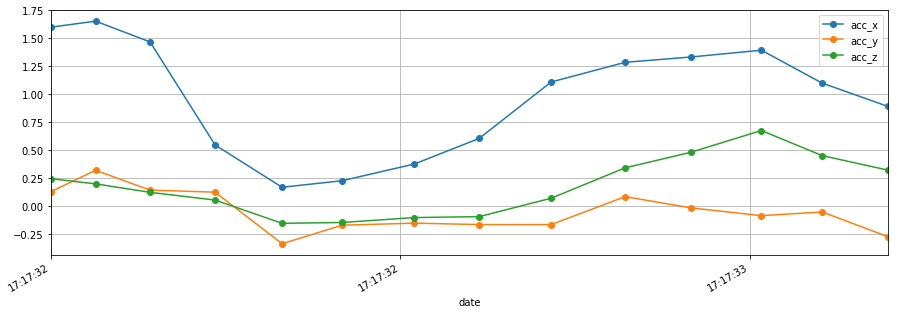

In [20]:
# first array is the figure, second is one motionset 
motionset['1'][-1][['acc_x', 'acc_y', 'acc_z']].plot(grid=True, figsize=(15,5), marker='o', linestyle='solid')

### Sample Plot on each figure

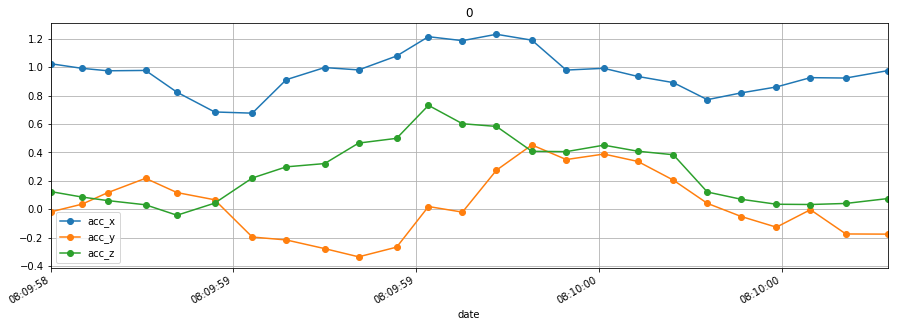

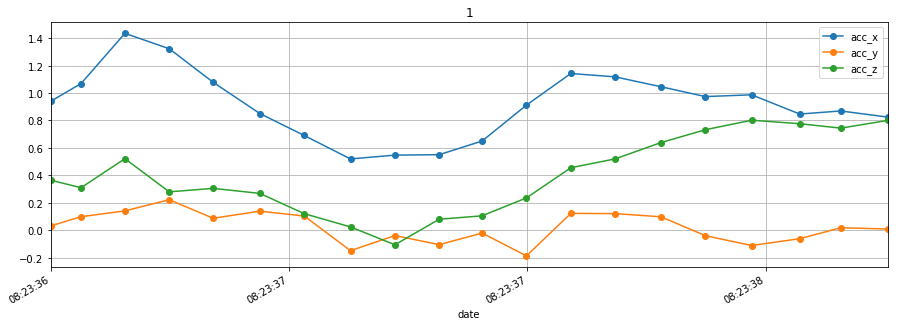

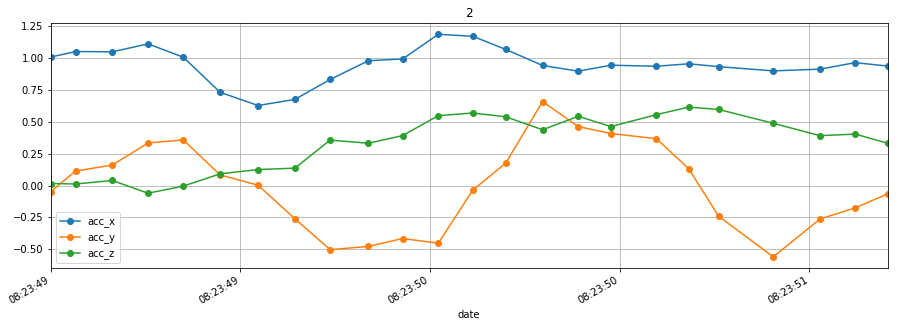

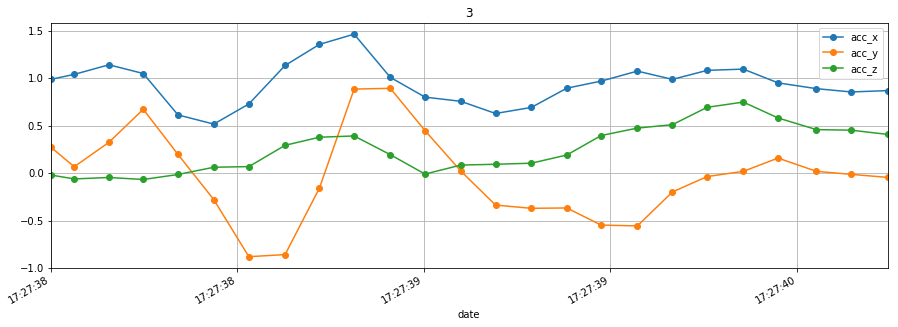

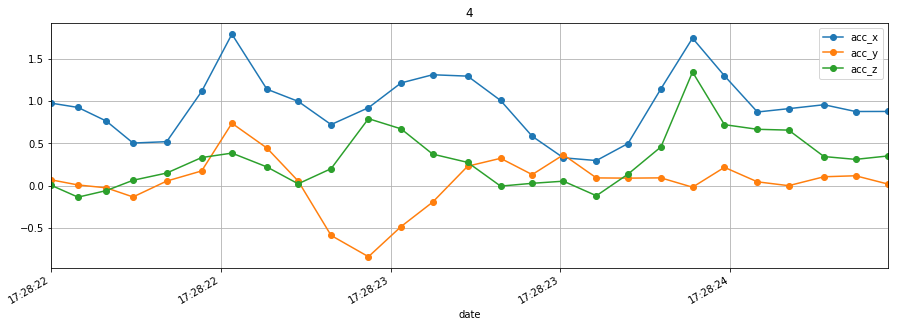

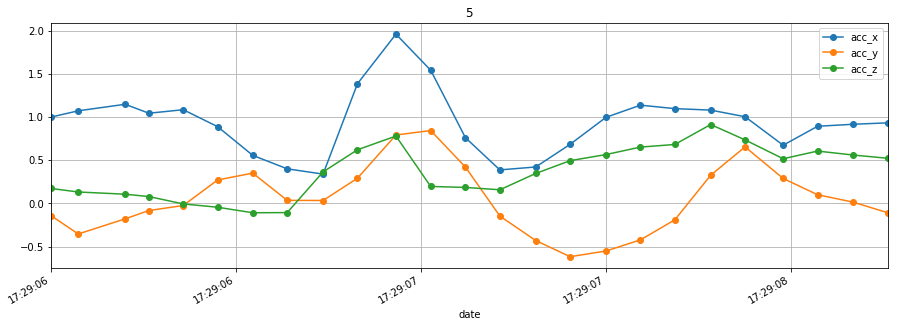

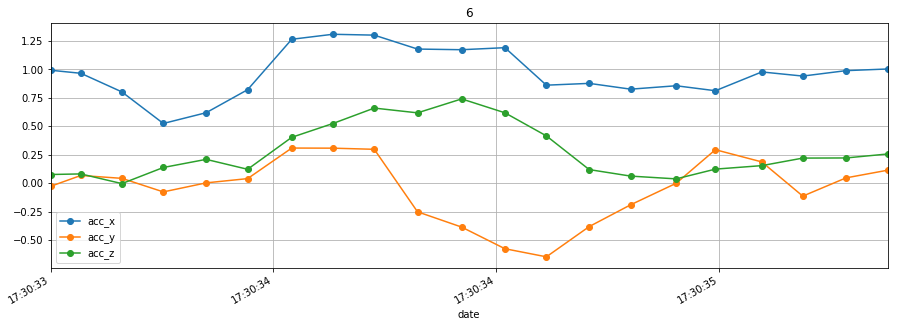

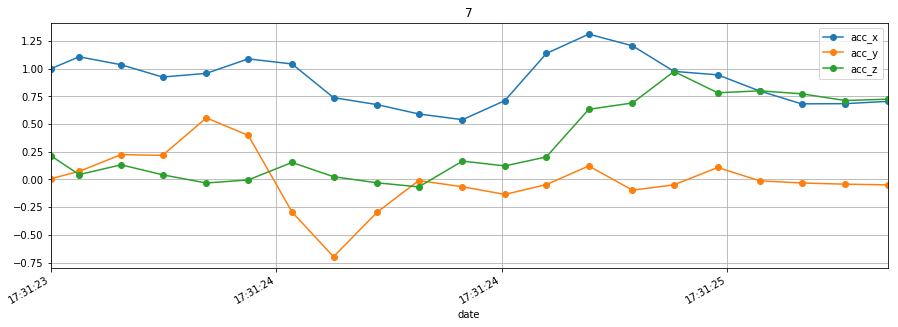

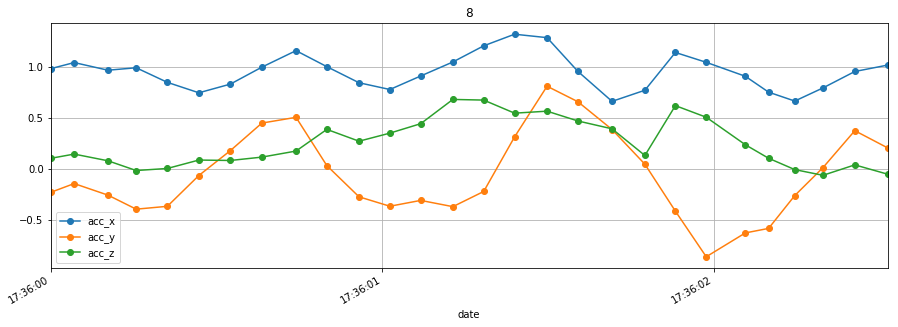

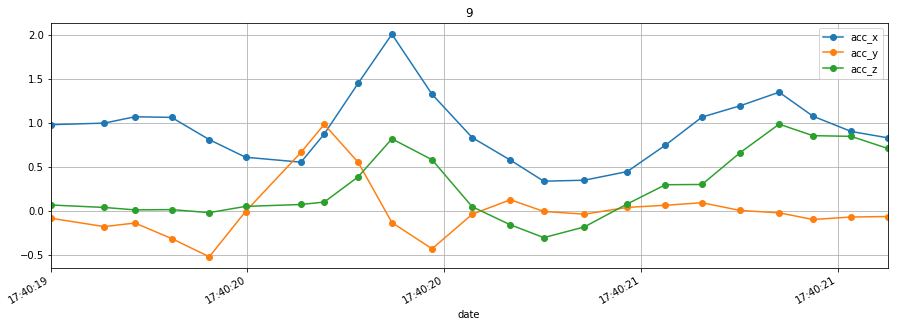

In [21]:
# get all figures and plot one figure to see its behavior 
for k in motionset.keys():
    motionset[k][0][['acc_x', 'acc_y', 'acc_z']].plot(title=k, grid=True, figsize=(15,5), marker='o', linestyle='solid')

### Sample Plot on each figure multiple motionsets
to get insights into the difference of each motionset (figure) and also on the same figure (two examples)

Total:20 Rows: 10 Cols:2


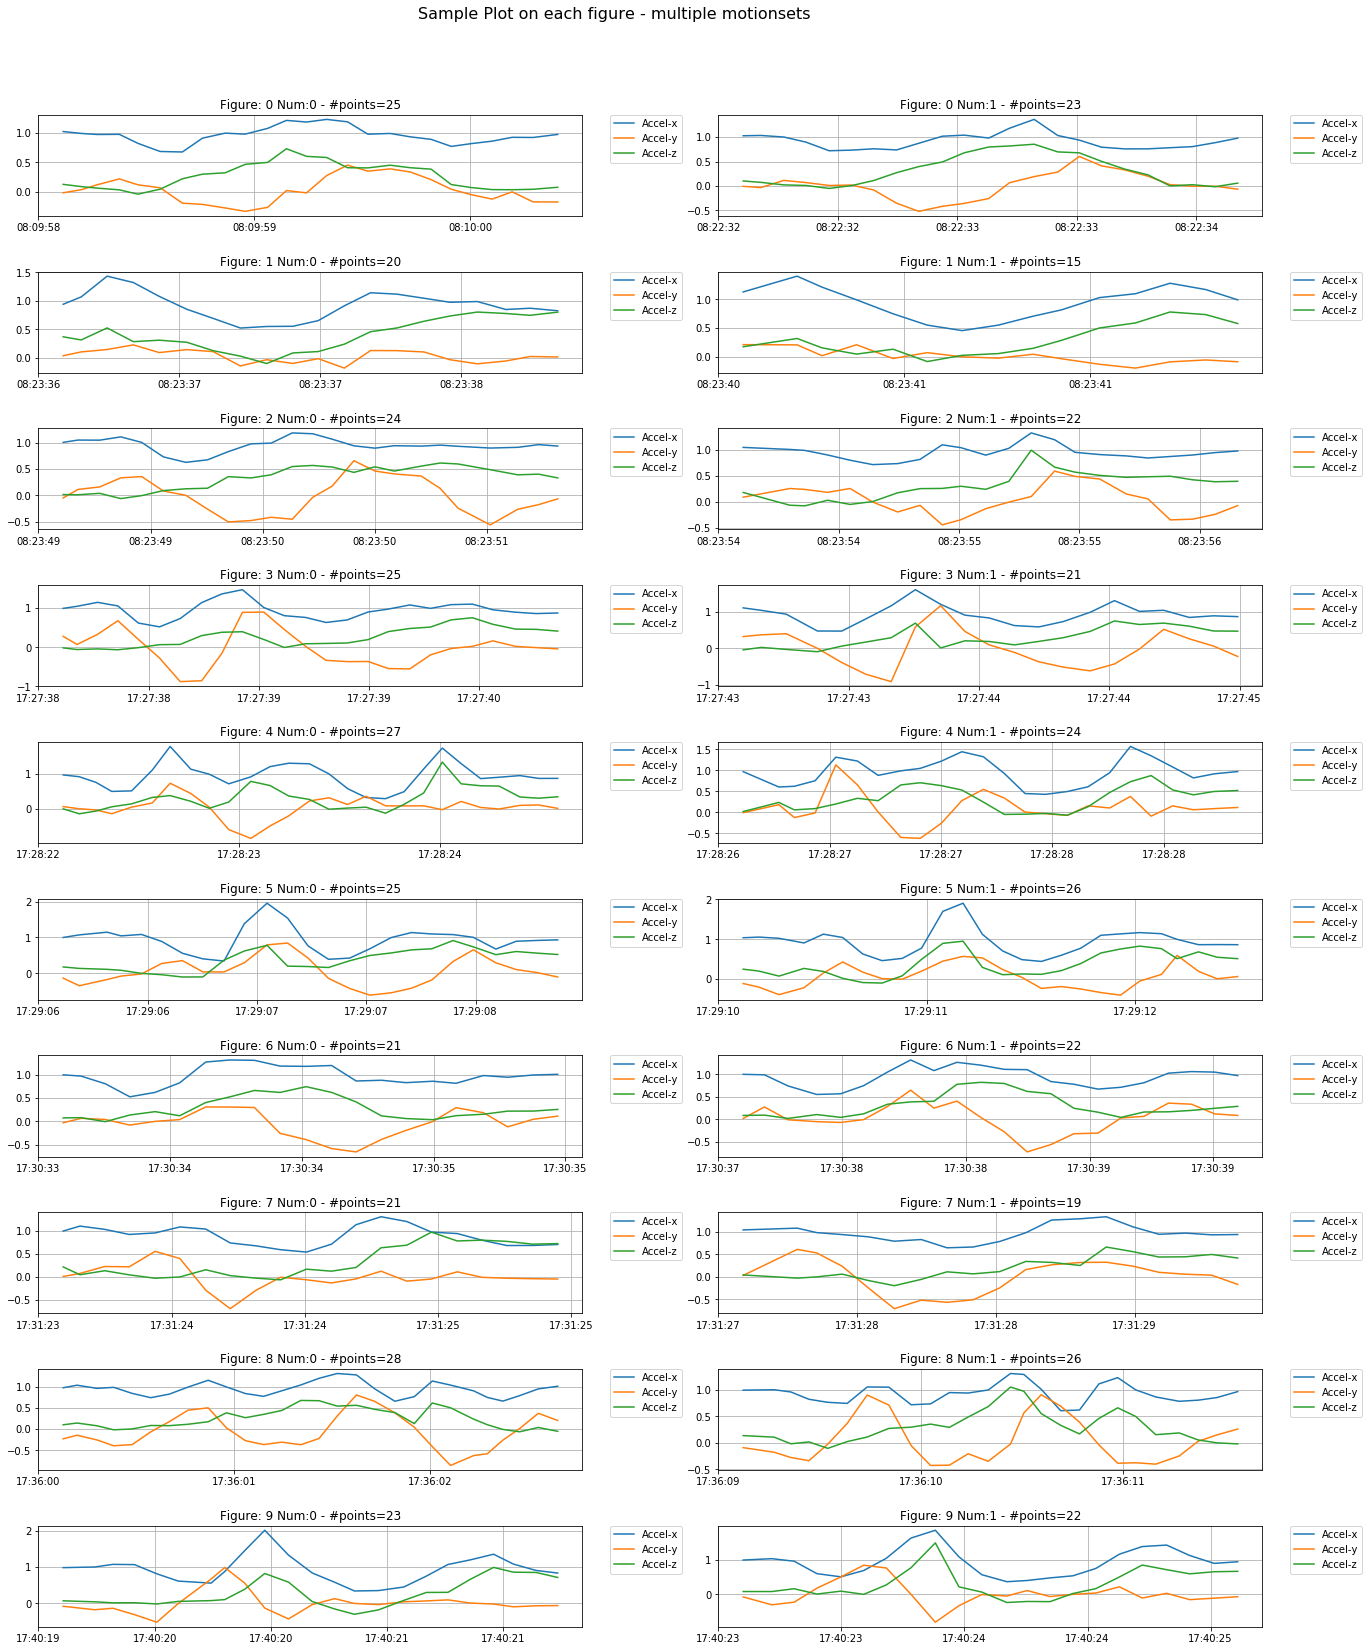

In [22]:
# Create main plot (as a figure to be displayed)
fig = plt.figure(1) 
fig.set_size_inches(20,25)
fig.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.25)
fig.suptitle('Sample Plot on each figure - multiple motionsets', fontsize=16)


# get all the possible figures
figures = sorted(motionset.keys())

# Get the Total Number of Figures (2 each)
Tot = len(figures) * 2

# Set the number of cols
Cols = 2

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

print('Total:' + str(Tot) + ' Rows: ' + str(Rows) + ' Cols:' + str(Cols))

# Create a Position index
Position = range(1,Tot + 1)

# Loop on every figure in the set
i = 0 
for f in figures:
    # two plots of each figure
    for l in range(2):
    
        # add subplot to the figure (left, right)
        ax = fig.add_subplot(Rows,Cols,Position[i])

        df = motionset[f][l]
        ax.plot(df.index, df[['acc_x']], label='Accel-x')
        ax.plot(df.index, df[['acc_y']], label='Accel-y')
        ax.plot(df.index, df[['acc_z']], label='Accel-z')

        ax.set_title('Figure: '+ f + ' Num:' + str(l) + " - #points={:g}".format(len(df)))
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        ax.grid(True)
        i+=1

plt.show()


## Build a train data-set

In [23]:
features = ['acc_x', 'acc_y', 'acc_z']

In [24]:
df = motionset['0'][5][features+['timestamp']]
df.head()

,acc_x,acc_y,acc_z,timestamp
date,,,,
2019-12-02 08:23:24.833000+00:00,1.0192,-0.0140,0.0858,1575275004833
2019-12-02 08:23:25.008000+00:00,0.9928,0.0007,0.0590,1575275005008
2019-12-02 08:23:25.081000+00:00,0.9831,0.0272,-0.0070,1575275005081
2019-12-02 08:23:25.180000+00:00,0.9191,0.1335,0.0621,1575275005180
2019-12-02 08:23:25.278000+00:00,0.7375,0.2243,-0.0239,1575275005278


In [25]:
df = df.set_index('timestamp')
df.head()

,acc_x,acc_y,acc_z
timestamp,,,
1575275004833,1.0192,-0.0140,0.0858
1575275005008,0.9928,0.0007,0.0590
1575275005081,0.9831,0.0272,-0.0070
1575275005180,0.9191,0.1335,0.0621
1575275005278,0.7375,0.2243,-0.0239


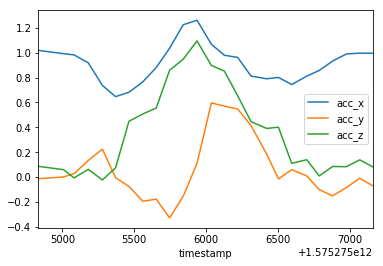

In [26]:
df.plot()

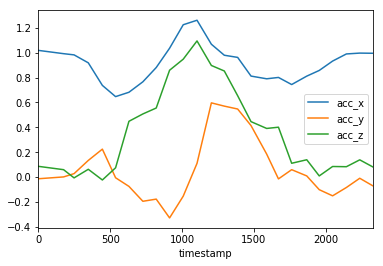

In [27]:
df.index -= df.index.min()
df.plot()

In [28]:
df.shape

(25, 3)

### Make all time series 25 points long

In [29]:
import numpy as np

In [30]:
t1, t2 = df.index.min(), df.index.max()
new_index = np.linspace(t1,t2,25)
new_index

array([   0.   ,   97.125,  194.25 ,  291.375,  388.5  ,  485.625,
        582.75 ,  679.875,  777.   ,  874.125,  971.25 , 1068.375,
       1165.5  , 1262.625, 1359.75 , 1456.875, 1554.   , 1651.125,
       1748.25 , 1845.375, 1942.5  , 2039.625, 2136.75 , 2233.875,
       2331.   ])

In [31]:
np.interp(new_index, df.index, df.values[:,0])

array([1.0192    , 1.004548  , 0.99024212, 0.9550596 , 0.84219796,
       0.69758152, 0.66436694, 0.72549356, 0.82817419, 0.97174113,
       1.15252553, 1.2484293 , 1.143082  , 1.01105208, 0.96789839,
       0.84979785, 0.7976    , 0.79885808, 0.75347065, 0.79741226,
       0.85121954, 0.92640995, 0.9862651 , 0.99717151, 0.996     ])

In [32]:
ip = DataFrame (
    data = dict((col, np.interp(new_index, df.index, df[col].values)) for col in features)
)

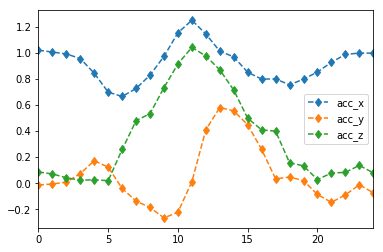

In [33]:
ip.plot(style=['d--', 'd--', 'd--' ])

### Standard function to create a normalized timeline

In [34]:
def make_normalized_data(df, w=25):
    df = df.set_index('timestamp')
    df.index = df.index - df.index.min()
    t1, t2 = df.index.min(), df.index.max()
    new_index = np.linspace(t1,t2,w)
    
    ip = DataFrame (
    data = dict((col, np.interp(new_index, df.index, df[col].values)) for col in df.columns)
    )
    return ip

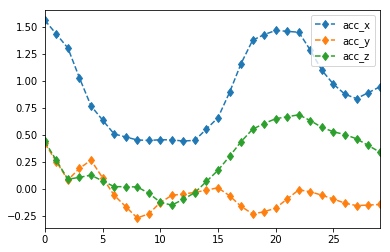

In [35]:
ip = make_normalized_data(motionset['1'][5][features+['timestamp']], w=30)
ip.plot(style=['d--', 'd--', 'd--'])

### Clean datasets which doesn´t fit
for example: no motion but a figure or motion is too short 

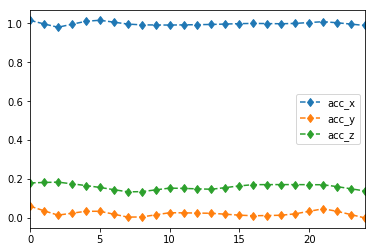

In [36]:
# is a flat line - no motion - for example number 28 in the array of '0'
ip = make_normalized_data(motionset['0'][28][features+['timestamp']], w=25)
ip.plot(style=['d--', 'd--', 'd--'])

In [37]:
from pandas import Series

In [38]:
counts = Series([len(df) for df in motionset['0']])
print(counts)

0     25
1     23
2     23
3     23
4     28
5     25
6     21
7     22
8     20
9     25
10    22
11    22
12    25
13    22
14    24
15    20
16    23
17    26
18    24
19    25
20    20
21    23
22    21
23    20
24    20
25    18
26    20
27    40
28    10
dtype: int64


(array([ 1.,  0.,  1.,  8., 11.,  6.,  1.,  0.,  0.,  1.]),
 array([10., 13., 16., 19., 22., 25., 28., 31., 34., 37., 40.]),
 <a list of 10 Patch objects>)

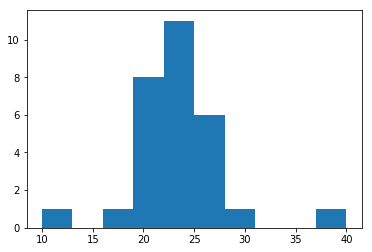

In [39]:
plt.hist(counts)

In [40]:
q25 = counts.quantile(0.25)
q75 = counts.quantile(0.75)
print('quantile: ', q25, q75)

quantile:  20.0 25.0


In [41]:
lower = q25 - 2 * (q75 - q25)
upper = q75 + 2 *(q75 - q25)
print('bounds:', lower, upper)

bounds: 10.0 35.0


### Clean the whole array where data is not sufficiant

In [42]:
# build one vector
ip.values.reshape(-1)

array([ 1.01610000e+00,  6.00000000e-02,  1.79600000e-01,  9.97651838e-01,
        3.61860294e-02,  1.81848529e-01,  9.80660326e-01,  1.38271739e-02,
        1.83621739e-01,  9.95957880e-01,  2.37233696e-02,  1.74858696e-01,
        1.01125543e+00,  3.36195652e-02,  1.66095652e-01,  1.01661598e+00,
        3.36747423e-02,  1.56320619e-01,  1.00680000e+00,  1.87000000e-02,
        1.45000000e-01,  9.96984021e-01,  3.72525773e-03,  1.33679381e-01,
        9.92803261e-01,  4.39673913e-03,  1.34701087e-01,  9.92312228e-01,
        1.53127717e-02,  1.43804076e-01,  9.91821196e-01,  2.62288043e-02,
        1.52907065e-01,  9.92823077e-01,  2.56129808e-02,  1.51253846e-01,
        9.93892308e-01,  2.44769231e-02,  1.49115385e-01,  9.94961538e-01,
        2.33408654e-02,  1.46976923e-01,  9.97017204e-01,  1.85811828e-02,
        1.55437097e-01,  9.99109677e-01,  1.36862903e-02,  1.64292742e-01,
        1.00033958e+00,  1.05750000e-02,  1.70652083e-01,  9.99434635e-01,
        1.18781250e-02,  

In [43]:
features = ['acc_x' ,'acc_y', 'acc_z'] # + ['gyro_x', 'gyro_y', 'gyro_z']

# vectors will contain all relevant feature vectors
vectors = []

# the corresponfing labels
labels = []

# loop over all motion sets
for figure, datasets in motionset.items():
    
    # comput robus upper and lower bounds on length
    counts = Series([len(df) for df in datasets])
    q25 = np.floor(counts.quantile(0.25))
    q75 = np.ceil(counts.quantile(0.75))
    lower = q25 - 2*(q75-q25)
    upper = q75 + 2*(q75-q25)
    
    # for each data set ...
    for df in datasets:
        # ... check its length
        if lower <= len(df) <= upper:
            # if long enough compute its normalized version
            ip = make_normalized_data(df[features + ['timestamp']])
            
            # if it has sufficient variance add it as a training example
            variance =  ip.var().sum()
            if variance > 0.01:
                vectors.append(ip.values.reshape(-1))
                labels.append(figure)
            else:
                print("Skipping motion for '{}': total variance {} to small.".format(figure, variance))
        else:
            print("Skipping motion for '{}': length {} not in range [{}, {}]".format(figure, len(df), lower, upper))

Skipping motion for '0': length 40 not in range [10.0, 35.0]
Skipping motion for '0': total variance 0.00047438406749113616 to small.
Skipping motion for '7': length 11 not in range [14.0, 24.0]
Skipping motion for '9': length 34 not in range [17.0, 27.0]


In [44]:
labels[0:200:10]

['0',
 '0',
 '0',
 '1',
 '1',
 '2',
 '2',
 '2',
 '3',
 '3',
 '4',
 '4',
 '4',
 '5',
 '5',
 '6',
 '6',
 '7',
 '7',
 '8']

### Convert to design matrix X and label vector Y

In [45]:
X = DataFrame(vectors)
Y = Series(labels)

In [46]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,...,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,1.035719,0.088265,0.120109,1.024654,0.054839,0.087451,0.957849,0.057962,0.065478,0.859209,...,0.497328,0.947856,0.000532,0.464209,0.930691,0.009422,0.422230,0.914809,0.001510,0.413089
std,0.124307,0.163795,0.108527,0.207648,0.237674,0.114641,0.264958,0.293573,0.114037,0.266037,...,0.332352,0.139735,0.173463,0.316030,0.104469,0.148230,0.280755,0.091231,0.116440,0.255226
min,0.646400,-0.339900,-0.142200,0.434915,-0.528824,-0.115504,0.341694,-0.647454,-0.158275,0.265845,...,-0.114598,0.636966,-0.513396,-0.237079,0.642169,-0.644933,-0.244962,0.595700,-0.521500,-0.270000
25%,0.989625,-0.021950,0.047625,0.949405,-0.091770,0.014873,0.811370,-0.123318,-0.003463,0.687176,...,0.227336,0.867380,-0.095338,0.246623,0.870788,-0.072677,0.245626,0.870550,-0.074300,0.233425
50%,1.016800,0.089250,0.095250,1.020724,0.065140,0.066624,0.983495,0.079295,0.042827,0.881952,...,0.507328,0.948592,-0.013276,0.474047,0.931859,-0.010712,0.448371,0.932350,-0.010150,0.448300
75%,1.048600,0.193800,0.182475,1.095510,0.197621,0.128839,1.054593,0.255971,0.111202,1.012868,...,0.688936,1.006029,0.112892,0.657266,0.989024,0.076513,0.611766,0.975475,0.074725,0.596700
max,1.622700,0.666000,0.477400,1.829133,0.660143,0.555359,1.764264,0.806500,0.499407,1.690285,...,1.586997,1.462059,0.570673,1.707280,1.420938,0.502572,1.100656,1.120600,0.514200,0.971400


In [47]:
Y.describe()

count     232
unique     10
top         2
freq       28
dtype: object

## Finally apply a classifier

In [48]:
from sklearn.svm import SVC

### Directly apply a support vector classifier

In [49]:
svm = SVC(gamma='auto')
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Create the predict on the model

In [50]:
y_pred = svm.predict(X)

### Confusion Matrix - show the quality 

In [51]:
from sklearn.metrics import confusion_matrix

In [52]:
labels = sorted(motionset.keys())

C = confusion_matrix(Y, y_pred, labels=labels)
C

array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 23,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 28,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 21,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 22,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 23,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 19]])

In [53]:
C = DataFrame(C, columns=labels, index=labels)
C.index.name = 'true'
C.columns.name = 'pred'
C

pred,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,27,0,0,0,0,0,0,0,0,0
1,0,23,0,0,0,0,0,0,0,0
2,0,0,27,1,0,0,0,0,0,0
3,0,0,0,19,0,1,0,0,0,0
4,0,0,0,0,28,0,0,0,0,0
5,0,0,0,0,0,21,0,0,0,0
6,0,0,0,0,0,0,21,0,0,0
7,0,0,0,0,0,0,0,22,0,0
8,0,0,0,0,0,0,0,0,23,0


### Drive the quality

In [54]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

In [55]:
accuracy_score(Y, y_pred)

0.9913793103448276

In [56]:
recall_score(Y, y_pred, average='weighted')

0.9913793103448276

In [57]:
print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        28
           3       0.95      0.95      0.95        20
           4       1.00      1.00      1.00        28
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        19

   micro avg       0.99      0.99      0.99       232
   macro avg       0.99      0.99      0.99       232
weighted avg       0.99      0.99      0.99       232



#### Detailed look on the wrong classifications

In [58]:
wrong = np.where(y_pred != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,65,2,3
1,81,3,5


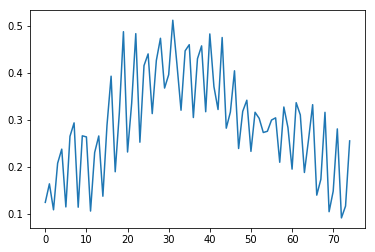

In [59]:
plt.plot(X.std())

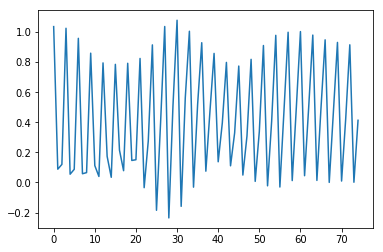

In [60]:
plt.plot(X.mean())

In [61]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X0 = scaler.transform(X)

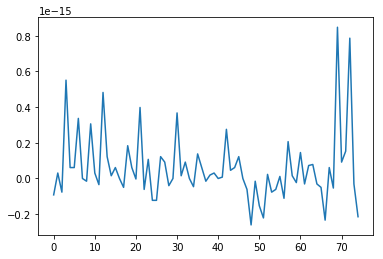

In [62]:
plt.plot(X0.mean(axis=0))

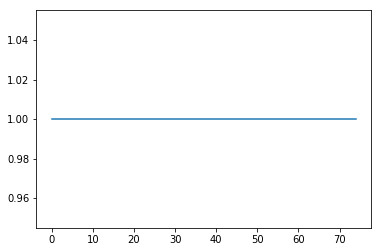

In [63]:
plt.plot(X0.std(axis=0))

## Combine scaler and classifier in a pipeline

In [64]:
from sklearn.pipeline import Pipeline

In [65]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(gamma='auto'))
])

In [66]:
model.fit(X,Y)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [67]:
y_pred_train = model.predict(X)
print(classification_report(Y, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        28
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      1.00      1.00        19

   micro avg       1.00      1.00      1.00       232
   macro avg       1.00      1.00      1.00       232
weighted avg       1.00      1.00      1.00       232



## Assess the generalization capability by crossvalidation

In [68]:
from sklearn.model_selection import cross_validate

In [69]:
cv = cross_validate(model, X, Y, cv=10, return_train_score=False)
DataFrame(data=cv)

,fit_time,score_time,test_score
0,0.023036,0.002165,1.000000
1,0.014385,0.002112,0.961538
2,0.045749,0.002127,1.000000
3,0.014352,0.001969,1.000000
4,0.014609,0.001997,1.000000
5,0.014401,0.002023,0.956522
6,0.015010,0.002004,0.956522
7,0.015170,0.001985,1.000000
8,0.014724,0.001961,1.000000
9,0.014861,0.001898,1.000000


In [70]:
DataFrame(data=cv).min()

fit_time      0.014352
score_time    0.001898
test_score    0.956522
dtype: float64

In [71]:
DataFrame(data=cv).mean()

fit_time      0.018630
score_time    0.002024
test_score    0.987458
dtype: float64

In [72]:
from sklearn.model_selection import cross_val_predict

In [73]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)

In [74]:
wrong = np.where(y_pred_cv != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred_cv[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,65,2,3
1,81,3,5
2,226,9,4


In [75]:
print(classification_report(Y, y_pred_cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        28
           3       0.95      0.95      0.95        20
           4       0.97      1.00      0.98        28
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      0.95      0.97        19

   micro avg       0.99      0.99      0.99       232
   macro avg       0.99      0.99      0.99       232
weighted avg       0.99      0.99      0.99       232



### Let's try to impove the classifier

In [76]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='rbf', gamma='auto'))
])

In [77]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)

In [78]:
print(classification_report(Y, y_pred_cv))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        28
           3       0.95      0.95      0.95        20
           4       0.97      1.00      0.98        28
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      0.95      0.97        19

   micro avg       0.99      0.99      0.99       232
   macro avg       0.99      0.99      0.99       232
weighted avg       0.99      0.99      0.99       232



### Automatic meta parameter search

In [79]:
from sklearn.model_selection import GridSearchCV

In [80]:
gamma0 = 1.0 / (X.shape[1]*X.std().std())

svm_cv = GridSearchCV(
    estimator=model, 
    param_grid = [
        {
            'svc__kernel' : ['rbf'],
            'svc__C' : [1, 0.1, 0.01],
            'svc__gamma' : np.array([1/10, 1/5, 1/2, 1, 2, 4])*gamma0
        },
        {
            'svc__kernel' : ['linear'],
            'svc__C' : [1, 0.1, 0.01]
        }
    ],
    cv=10,
    iid=True,
    refit=True,
    verbose=2
)


In [81]:
svm_cv.fit(X,Y)

Fitting 10 folds for each of 21 candidates, totalling 210 fits
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf ......
[CV]  svc__C=1, svc__gamma=0.012147789016270465, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf .......
[CV]  svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf .......
[CV]  svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf .......
[CV]  svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf .......
[CV]  svc__C=1, svc__gamma=0.02429557803254093, svc__kernel=rbf, total=   0.0s
[CV] svc__C=1, svc

[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    7.1s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=None,
       param_grid=[{'svc__kernel': ['rbf'], 'svc__C': [1, 0.1, 0.01], 'svc__gamma': array([0.01215, 0.0243 , 0.06074, 0.12148, 0.24296, 0.48591])}, {'svc__kernel': ['linear'], 'svc__C': [1, 0.1, 0.01]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [82]:
svm_cv.best_params_

{'svc__C': 1, 'svc__gamma': 0.012147789016270465, 'svc__kernel': 'rbf'}

In [83]:
svm_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.012147789016270465,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [84]:
svm_cv.best_score_

0.9913793103448276

## Train final model and deploy to Watson Machine Learning (WML)
the WML should be installed - better upgrade to most recent version

In [85]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.382)



### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform api_key and instance location.

You can use IBM Cloud CLI to retrieve platform API Key and instance location.

API Key can be generated in the following way:

    ibmcloud login
    ibmcloud iam api-key-create API_KEY_NAME

In result, get the value of api_key from the output.

Location of your WML instance can be retrieved in the following way:

    ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
    ibmcloud resource service-instance WML_INSTANCE_NAME

In result, get the value of location from the output.

Tip: Your Cloud API key can be generated by going to the Users section of the Cloud console. From that page, click your name, scroll down to the API Keys section, and click Create an IBM Cloud API key. Give your key a name and click Create, then copy the created key and paste it below.
You can also get service specific apikey by going to the Service IDs section of the Cloud Console. From that page, click Create, then copy the created key and paste it below.

Action: Enter your api_key and location in the following cell.


In [86]:
from ibm_watson_machine_learning import APIClient
# from watson_machine_learning_client import WatsonMachineLearningAPIClient

2020-09-18 10:51:09,744 - ibm_watson_machine_learning.wml_client_error - WARNING - Deployment creation failed. Error: 402. {"trace":"42950a15e8adc617f88966c7c349557e","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


In [87]:
# @hiddel_cell

# create a API Key (general or service key) in IBM Cloud to access this services 
api_key = 'ulPx20TY7Kb_oNFx_fGsJ19mV54ZhKs-5JwCEm0q2_IF'
location = 'us-south'

wml_credentials = {
    "apikey" : api_key, 
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Instantiate a client
Remember - only 5 deploymens cloud be done in the lite plan !

In [88]:
wml_client = APIClient(wml_credentials)
#wml_client = WatsonMachineLearningAPIClient(wml_credentials)

In [89]:
# Goto IBM Cloud CloudPack for Data and select the space where to deploy the model (in settings you find the space_id)
space_id = '4d71904b-afa0-4a69-a8d8-eeafaef6f04f'

In [90]:
# Set space to default for better working 
wml_client.spaces.list(limit=10)

wml_client.set.default_space(space_id)

------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
4d71904b-afa0-4a69-a8d8-eeafaef6f04f  TjBot-Deployment  2020-09-16T06:29:45.997Z
------------------------------------  ----------------  ------------------------


'SUCCESS'

In [91]:
import json

instance_details = wml_client.service_instance.get_details()
print(json.dumps(instance_details, indent=2))

{
  "entity": {
    "account": {
      "id": "19f662d586832d82b96df0d107630ba9"
    },
    "consumption": {
      "capacity_unit_hours": {
        "current": 19.96055555555556,
        "limit": 20.0
      },
      "do_job_count": {
        "limit": 2
      },
      "gpu_count": {
        "limit": 1
      }
    },
    "crn": "crn:v1:bluemix:public:pm-20:us-south:a/19f662d586832d82b96df0d107630ba9:850d19b2-bced-4c85-9994-af532ca66a20::",
    "plan": {
      "id": "3f6acf43-ede8-413a-ac69-f8af3bb0cbfe",
      "name": "lite",
      "version": 2
    },
    "service_endpoints": "public",
    "status": "Active"
  },
  "metadata": {
    "created_at": "2019-01-24T16:23:54.541Z",
    "modified_at": "2019-01-24T16:23:54.541Z",
    "tags": [
      "created_in_v1_plan"
    ],
    "id": "850d19b2-bced-4c85-9994-af532ca66a20"
  }
}


### Build the final model

In [92]:
# use parameters from the GridSearch Hyperparameters

final = model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(C= 1, kernel='rbf'))
])

y_pred_cv = cross_val_predict(final, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

final.fit(X,Y)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        23
           2       1.00      0.96      0.98        28
           3       0.95      0.95      0.95        20
           4       0.97      1.00      0.98        28
           5       0.95      1.00      0.98        21
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        23
           9       1.00      0.95      0.97        19

   micro avg       0.99      0.99      0.99       232
   macro avg       0.99      0.99      0.99       232
weighted avg       0.99      0.99      0.99       232



Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

#### Get  metadata

In [93]:
wml_client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b84-d6ed-5dde-b6a5-3fbdf1665666  base
tensorflow_1.15-py3.6          2b73a275-7cbf-420b-a912-eae7f436e0bc  base
pytorch_1.2-py3.6              2c8ef57

In [94]:
# For deployment you have to get the right runtime spec for the model itself - here scikit-learn on python

software_spec_uid = wml_client.software_specifications.get_id_by_name("scikit-learn_0.20-py3.6")
software_spec_uid

'09c5a1d0-9c1e-4473-a344-eb7b665ff687'

In [95]:
# set the model properties to get ready for deployment
model_props = {
            wml_client.repository.ModelMetaNames.NAME: 'Motion based digit classification for RasPi',
            wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.20',
            wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

model_props

{'name': 'Motion based digit classification for RasPi',
 'type': 'scikit-learn_0.20',
 'software_spec': '09c5a1d0-9c1e-4473-a344-eb7b665ff687'}

In [96]:
wml_client.repository.ModelMetaNames.show()

------------------------  ----  --------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
META_PROP NAME            TYPE  REQUIRED  SCHEMA
NAME                      str   Y
DESCRIPTION               str   N
INPUT_DATA_SCHEMA         list  N         {'id(required)': 'string', 'fields(required)': [{'name(required)': 'string', 'type(required)': 'string', 'nullable(optional)': 'string'}]}
TRAINING_DATA_REFERENCES  list  N         [{'name(optional)': 'string', 'type(required)': 'string', 'connection(required)': {'endpoint_url(required)': 'string', 'access_key_id(required)': 'string', 'secret_access_key(required)': 'string'},

#### Publish the new model into the repository

In [97]:
published_model = wml_client.repository.store_model(
    model=model,
    meta_props=model_props)

In [100]:
wml_client.repository.list_models()

------------------------------------  -------------------------------------------  ------------------------  -----------------
ID                                    NAME                                         CREATED                   TYPE
bd643160-3c92-40b5-af7d-9491894cbf10  Motion based digit classification for RasPi  2020-09-18T10:49:40.002Z  scikit-learn_0.20
------------------------------------  -------------------------------------------  ------------------------  -----------------


In [101]:
published_model_uid = wml_client.repository.get_model_uid(published_model)
model_details = wml_client.repository.get_details(published_model_uid)
# print(json.dumps(model_details, indent=2))
published_model_uid

'bd643160-3c92-40b5-af7d-9491894cbf10'

In [102]:
# Delete not needed models 
#wml_client.repository.delete('f2dc4180-d5c2-4550-8001-c050ec673fd8')

#### Creating a deployment (i.e. the callable WEB service)

In [103]:
# List existing deployments
wml_client.deployments.list()

----  ----  -----  -------
GUID  NAME  STATE  CREATED
----  ----  -----  -------


In [104]:
# Getting current hardware specifications
wml_client.hardware_specifications.list() 

-------------  ------------------------------------  --------------------------------------------------------------------------------------------------------------------------------------
NAME           ID                                    DESCRIPTION
ML             7a46ecc7-0ea9-4c94-a444-fbda4d6adc4a  A hardware specification providing 4 CPU cores and 32 GiB of memory.
V100x2         a02f3ab5-6964-4f06-a870-c7cc69187895  A hardware specification providing 52 CPU cores and 96 GiB of memory with 2 Nvidia v100 GPUs.
L              a6c4923b-b8e4-444c-9f43-8a7ec3020110  A hardware specification providing 8 CPU cores and 32 GiB of memory.
Default Spark  ac59d20a-9c7c-4504-a853-788ef35969da  A hardware specification for Spark with 1 CPU and 4 GiB of memory for master and worker nodes, with 2 workers.
XXS            b128f957-581d-46d0-95b6-8af5cd5be580  A hardware specification providing one CPU core and 2 GiB of memory.
M-Spark        b2232f7a-bfad-4822-9bce-6ba1af49217a  A hardware specif

In [105]:
# Set the hardware spec for the right deployment (2 CPU cores and 8 GB = 'S')
hardware_spec_id = wml_client.hardware_specifications.get_id_by_name('S')

In [106]:
# set metatdata for the deployment itself
metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Motion based digit classification for RasPi Deployment",
    wml_client.deployments.ConfigurationMetaNames.HARDWARE_SPEC: { "id": hardware_spec_id},
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = wml_client.deployments.create(published_model_uid, meta_props=metadata)

{"trace":"42950a15e8adc617f88966c7c349557e","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}


--------------------------
Deployment creation failed
--------------------------




WMLClientError: Deployment creation failed. Error: 402. {"trace":"42950a15e8adc617f88966c7c349557e","errors":[{"code":"instance_quota_exceeded","message":"This deployment cannot be processed because it exceeds the allocated capacity unit hours (CUH). Increase the compute resources for this job and try again."}]}

In [ ]:
print(json.dumps(created_deployment, indent=2))

In [ ]:
# maybe delete the not used deployment
# wml_client.deployments.delete('f73dcdcd-489a-4498-9099-2381132b51b3')

### Use the deployed model via the client

In [ ]:
# furtheron the deployment_uid is the referance to the right deployment itself
deployment_uid = wml_client.deployments.get_uid(created_deployment)
deployment_uid

In [ ]:
#model_scoring_url = wml_client.deployments.get_scoring_url(created_deployment)
model_scoring_url = wml_client.deployments.get_scoring_href(created_deployment)
model_scoring_url

In [ ]:
# new API needs a special payload with the valid values
scoring_payload = {"input_data": [{"values": [list(X.iloc[1,:])]}]}
print(scoring_payload)

In [ ]:
# call the deployed model with a motion and compare to the original data 

#wml_client.deployments.score(model_scoring_url, {"values" : [list(X.iloc[1,:])]})
wml_client.deployments.score(deployment_uid, scoring_payload)

In [ ]:
# check if the prediction is the same 
list(Y)[1]

## Create a function to call this deployed model
With this function the data refinary, the checks and also the call of the original trained deployment is done

In [ ]:
# parameter for calling remote
ai_parms = {"wml_credentials": wml_credentials, 
            "space_id": space_id, 
            "deployment_uid": deployment_uid,
            "n_interp": 25,
            "min_number_of_events": 6
           }

# Function for doing the classification including transformation 
def digit_classification( parms=ai_parms ):
    
    # internal function to normalize the move into a feature matrix for calling
    def make_feature_matrix(values):
        """
        values is the array of motion events
        """
        import numpy as np
        # parameter:
        #   w ... number of points for interpolation. Must be the same as during learning the model
        w = parms['n_interp']

        # time stamps of recorded data in form of numpy vector
        t_rec = np.array([e['timestamp'] for e in values])

        # accelaration data in form of a numpy array of shape (len(payload),3)
        a_rec = np.array([
            [e['acceleration'][col] for col in ('x', 'y', 'z')] for e in values
        ])

        # make a regular linear space from the begining to the end
        t_int = np.linspace(t_rec[0], t_rec[-1], w)

        # now interpolate the x, y, and z coordinate
        a_int = np.zeros((w, 3))
        for j in (0,1,2):
            a_int[:,j] = np.interp(t_int, t_rec, a_rec[:,j])

        return a_int
    
    # external callable function for doing the scoring (must be named score)
    def score(payload):
            
        try:
            # import the client
            from ibm_watson_machine_learning import APIClient
            client = APIClient( parms["wml_credentials"] )
            
            # set the default space where the model is available
            client.set.default_space( parms["space_id"] )

            # scoring_payload = {"input_data": [{"values": [list(X.iloc[1,:])]}]}

            # get the values 
            values = payload["input_data"][0]["values"]
            if len(values[0]) < parms['min_number_of_events']:
                 return {"figure" : "<to-short>"}
            
            # print("Values:")
            # print(values)

            # create the feature matrix out of the values
            data = make_feature_matrix(values)
            
            # check if there is enough movement 
            variance = data.var(axis=0).sum()
            if variance < 0.01:
                return {"figure" : "<no-motion>"}
            
            payload = dict(values=[list(data.reshape(-1))])
            
            # create the callable scoring payload
            scoring_payload = {"input_data": [payload]}

            # print("scoring_payload:")
            # print(scoring_payload)
            
            # call the model with the vector
            model_result = client.deployments.score( parms['deployment_uid'], scoring_payload )
            
            # print("model_result")
            # print(model_result)
            
            # get the result out of the model
            digit_class  = model_result["predictions"][0]["values"][0]
            
            # return the detected figure 
            return { "figure" : digit_class }
            
        except Exception as e:
            return {'predictions': [{'values': [repr(e)]}]}
            # return { "error" : repr( e ) }

    return score

#### Test the function
get some original cloudantDB values of one motion to test 

In [ ]:
selector = {
    '_id':{'$gt': 0},
    'd.motionset': {
        '$gte': '2019-12-15T07:00',  # $gte: greater than or equal
        '$lt': '2019-12-16T00:00' # $lte: less than or equal
    },
    'd.figure': '4',
}

# Create the query ...
figure_query = Query(database, selector=selector, fields=fields)

# ... and get all motion sets
motionsets = sorted(set(e['d']['motionset'] for e in figure_query()['docs']))

# now pick one motionset and build a new query for the particular motionset
selector['d.motionset'] = motionsets[1]
figure_query = Query(database, selector=selector, fields=fields)

In [ ]:
# make a sorted array of events and remove the payload.d prefix
values = sorted([e['d'] for e in figure_query()['docs']], key=lambda e: e['timestamp'])
values[:2]

In [ ]:
payload = {
    'values': values
}
payload

In [ ]:
scoring_payload = {"input_data": [{"values": values}]}
print(scoring_payload)

In [ ]:
print(scoring_payload["input_data"][0])
print(payload)
print(scoring_payload)

In [ ]:
# now do the digit classification

digit_classification()(scoring_payload)

### Deploy function into repository and create deployment (callable)

In [ ]:
# see the possible software specifications
wml_client.software_specifications.list()

In [ ]:
# Look up software specification for the deployable function

sofware_spec_uid = wml_client.software_specifications.get_id_by_name("ai-function_0.1-py3.6")

In [ ]:
# Store the deployable function in your Watson Machine Learning repository

meta_data = {
    wml_client.repository.FunctionMetaNames.NAME: 'Motion based digit classification for RasPi Function',
    wml_client.repository.FunctionMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

function_details = wml_client.repository.store_function(meta_props=meta_data, function=digit_classification)

In [ ]:
# Get published function ID

function_uid = wml_client.repository.get_function_uid(function_details)

In [ ]:
# Deploy the stored function

metadata = {
    wml_client.deployments.ConfigurationMetaNames.NAME: "Motion based digit classification for RasPi function deployment",
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

function_deployment_details = wml_client.deployments.create(function_uid, meta_props=metadata)

In [ ]:
# delete the deployed function 
# wml_client.deployments.delete('4a24c0d7-2bb8-4491-8822-de69fe266027')

In [ ]:
# Get the endpoint URL of the function deployment just created

function_deployment_id = wml_client.deployments.get_uid(function_deployment_details)
function_deployment_endpoint_url = wml_client.deployments.get_scoring_href(function_deployment_details)
print(function_deployment_id)
print(function_deployment_endpoint_url)

#### Test with WML-Client

In [ ]:
# fill in the payload 
call_payload = {"input_data": [payload]}
print(call_payload)

In [ ]:
print(function_deployment_id)

In [ ]:
# call function with necesary payload
result = wml_client.deployments.score(function_deployment_id, call_payload)
if "error" in result:
    print(result["error"])
else:
    print(result)

In [ ]:
#result = wml_client.deployments.score( function_deployment_endpoint_url, payload)
#print (result)

#### Test as an REST API

In [ ]:
# Get an IAM token from IBM Cloud
url     = "https://iam.bluemix.net/oidc/token"
headers = {"Content-Type": "application/x-www-form-urlencoded"}
data    = "apikey=" + wml_credentials["apikey"] + "&grant_type=urn:ibm:params:oauth:grant-type:apikey"
IBM_cloud_iam_uid = "bx"
IBM_cloud_iam_pwd = "bx"
response  = requests.post(url, headers=headers, data=data, auth=(IBM_cloud_iam_uid, IBM_cloud_iam_pwd))

if 200 != response.status_code:
    print(response.status_code)
    print(response.reason)
else:
    iam_token = response.json()["access_token"]
    
    # Send data to deployment for processing
    headers = {"Content-Type"   : "application/json",
               "Authorization"  : "Bearer " + iam_token}
    params = {"version": "2020-08-01"}
    response = requests.post(function_deployment_endpoint_url, json=payload, params=params, headers=headers)
    print(response.text)

## Now its time to go to Raspi and ...
... implement the call to the WEB service access to the function digit_classification in Node.RED